<a href="https://colab.research.google.com/github/TracyWang0110/Machine-learning-projects/blob/main/cancer_final_model_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install h2o

     |████████████████████████████████| 164.8MB 82kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.3-py2.py3-none-any.whl size=164854343 sha256=c937e4838942ae7cb90664e48065f67890769d2e3764be943e5b527389b91f14
  Stored in directory: /root/.cache/pip/wheels/4f/bb/82/0988682f9abd0b5e95109a4aae6793dd427173b6dc671d9252
Successfully built h2o


In [ ]:
import numpy as np
from keras.models import Sequential 
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import sklearn 
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import auc, roc_curve, classification_report
from h2o.grid import H2OGridSearch


In [ ]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [ ]:
#not limit the display row
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:
test_data['cancer_type'] =  np.nan
train_data['label'] = 'train'
test_data['label'] ='test'

In [ ]:
df_pre = pd.concat([train_data.assign(ind="train"), test_data.assign(ind="test")],ignore_index=True)
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        569 non-null    float64
 1   texture_0       569 non-null    float64
 2   perimeter_0     569 non-null    float64
 3   radius_1        489 non-null    float64
 4   texture_1       569 non-null    float64
 5   perimeter_1     369 non-null    float64
 6   radius_2        569 non-null    float64
 7   texture_2       569 non-null    object 
 8   perimeter_2     569 non-null    float64
 9   age             569 non-null    int64  
 10  treatment_date  569 non-null    object 
 11  diagnose_date   569 non-null    object 
 12  cancer_type     398 non-null    float64
 13  label           569 non-null    object 
 14  ind             569 non-null    object 
dtypes: float64(9), int64(1), object(5)
memory usage: 66.8+ KB


In [ ]:
df_pre.groupby('ind').size()

ind
test     171
train    398
dtype: int64

In [ ]:
train_data.groupby('cancer_type').size()

cancer_type
0    148
1    250
dtype: int64

In [ ]:
#check the data type
#change the texture_2 from object to float
#in texture_2, there are some missing values filled with 'xx'
df_pre = df_pre.replace('xx', np.nan)
df_pre['texture_2'] = df_pre['texture_2'].astype(float)
df_pre['treatment_date'] = pd.to_datetime(df_pre['treatment_date'],format = '%Y-%m-%d')
df_pre['diagnose_date'] = pd.to_datetime(df_pre['diagnose_date'], format = '%Y-%m-%d')

In [ ]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   radius_0        569 non-null    float64       
 1   texture_0       569 non-null    float64       
 2   perimeter_0     569 non-null    float64       
 3   radius_1        489 non-null    float64       
 4   texture_1       569 non-null    float64       
 5   perimeter_1     369 non-null    float64       
 6   radius_2        569 non-null    float64       
 7   texture_2       541 non-null    float64       
 8   perimeter_2     569 non-null    float64       
 9   age             569 non-null    int64         
 10  treatment_date  569 non-null    datetime64[ns]
 11  diagnose_date   569 non-null    datetime64[ns]
 12  cancer_type     398 non-null    float64       
 13  label           569 non-null    object        
 14  ind             569 non-null    object        
dtypes: dat

In [ ]:
#extract time interval information 
df_pre['interval'] = (df_pre['treatment_date'] - df_pre['diagnose_date']).apply(lambda x:x.days)
#extract year information

df_pre['diagnose_year'] = pd.DatetimeIndex(df_pre['diagnose_date']).year
df_pre['diagnose_month'] = pd.DatetimeIndex(df_pre['diagnose_date']).month
df_pre['diagnose_day'] = pd.DatetimeIndex(df_pre['diagnose_date']).day

df_pre['treatment_year'] = pd.DatetimeIndex(df_pre['treatment_date']).year
df_pre['treatment_month'] = pd.DatetimeIndex(df_pre['treatment_date']).month
df_pre['treatment_day'] = pd.DatetimeIndex(df_pre['treatment_date']).day

In [ ]:
df_keep = df_pre
#drop colums
# I am not going to use those 2 variables
cols_drop=['texture_1','perimeter_2']
left_cols =list(set(df_pre.columns) - set(cols_drop))
df_c = df_pre.loc[:, df_pre.columns.isin(left_cols)]
df_c.head()


,radius_0,texture_0,perimeter_0,radius_1,perimeter_1,radius_2,texture_2,age,treatment_date,diagnose_date,cancer_type,label,ind,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day
0,19.858394,27.204437,136.324256,22.683290,119.523841,21.477052,27.307087,44,2006-06-03,2005-10-23,0.0,train,train,223,2005,10,23,2006,6,3
1,14.182069,15.754730,80.916983,14.043753,94.911073,15.012329,17.855131,59,2004-02-22,2007-08-20,1.0,train,train,-1275,2007,8,20,2004,2,22
2,25.380268,21.291553,152.281062,23.852166,NaN,28.563252,21.097153,37,2006-01-06,2004-08-07,0.0,train,train,517,2004,8,7,2006,1,6
3,11.835961,17.820702,72.178523,11.260258,NaN,12.082749,16.499237,51,2003-04-14,2005-06-16,1.0,train,train,-794,2005,6,16,2003,4,14
4,14.875600,17.534187,98.545830,14.380683,89.712492,12.930685,19.856687,21,2004-06-21,2002-11-27,1.0,train,train,572,2002,11,27,2004,6,21


In [ ]:
df_c.groupby('ind').size()

ind
test     171
train    398
dtype: int64

In [ ]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   radius_0         569 non-null    float64       
 1   texture_0        569 non-null    float64       
 2   perimeter_0      569 non-null    float64       
 3   radius_1         489 non-null    float64       
 4   perimeter_1      369 non-null    float64       
 5   radius_2         569 non-null    float64       
 6   texture_2        541 non-null    float64       
 7   age              569 non-null    int64         
 8   treatment_date   569 non-null    datetime64[ns]
 9   diagnose_date    569 non-null    datetime64[ns]
 10  cancer_type      398 non-null    float64       
 11  label            569 non-null    object        
 12  ind              569 non-null    object        
 13  interval         569 non-null    int64         
 14  diagnose_year    569 non-null    int64    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15abd14c50>,
      dtype=object)

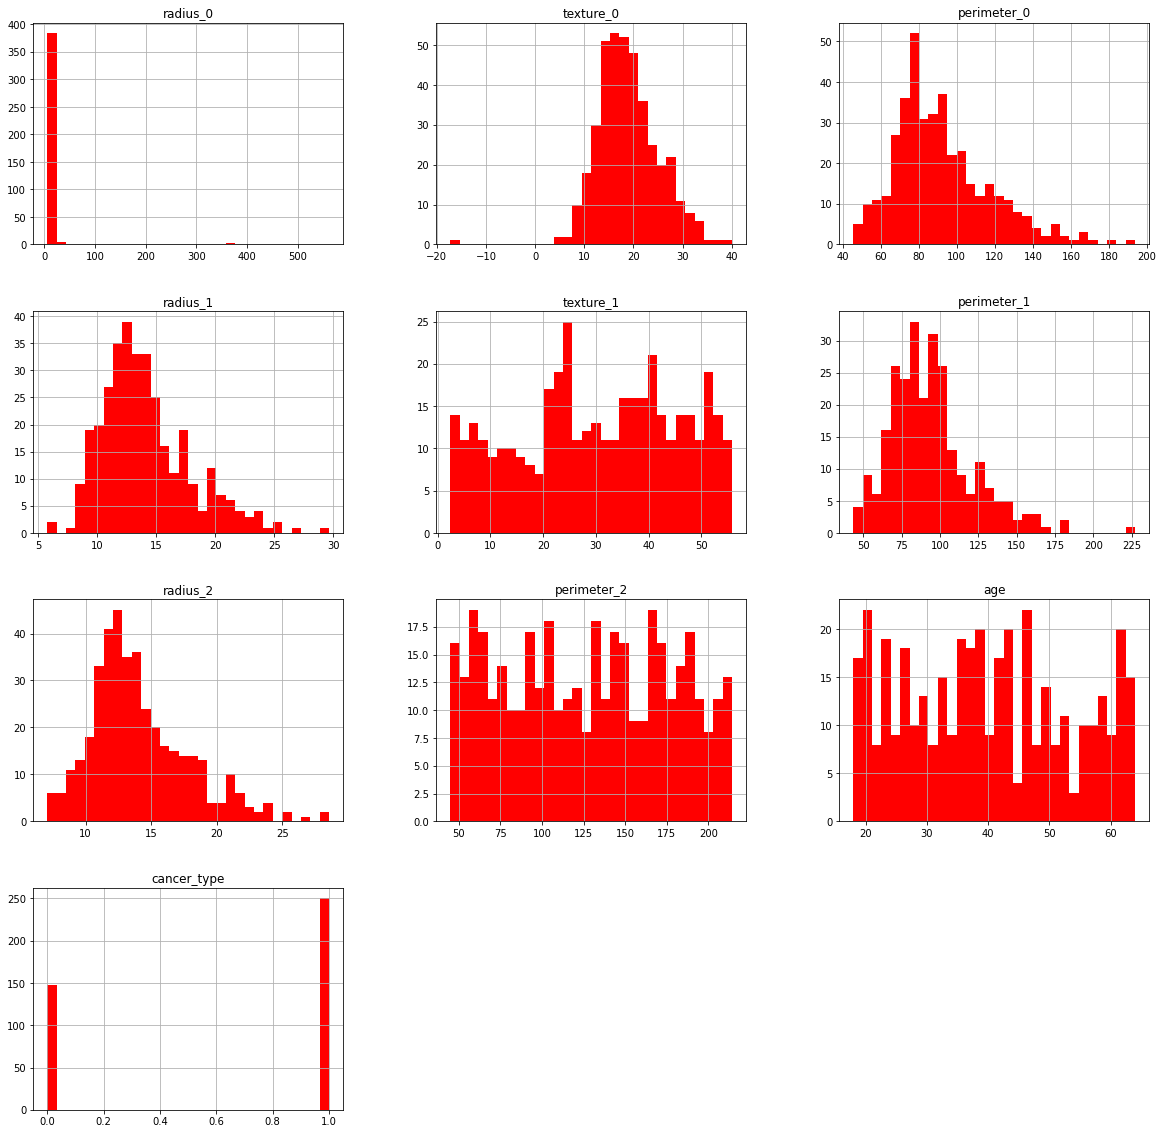

In [ ]:
train_data.hist(bins = 30, figsize = (20,20), color = 'r')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ab0306d0>,
      dtype=object)

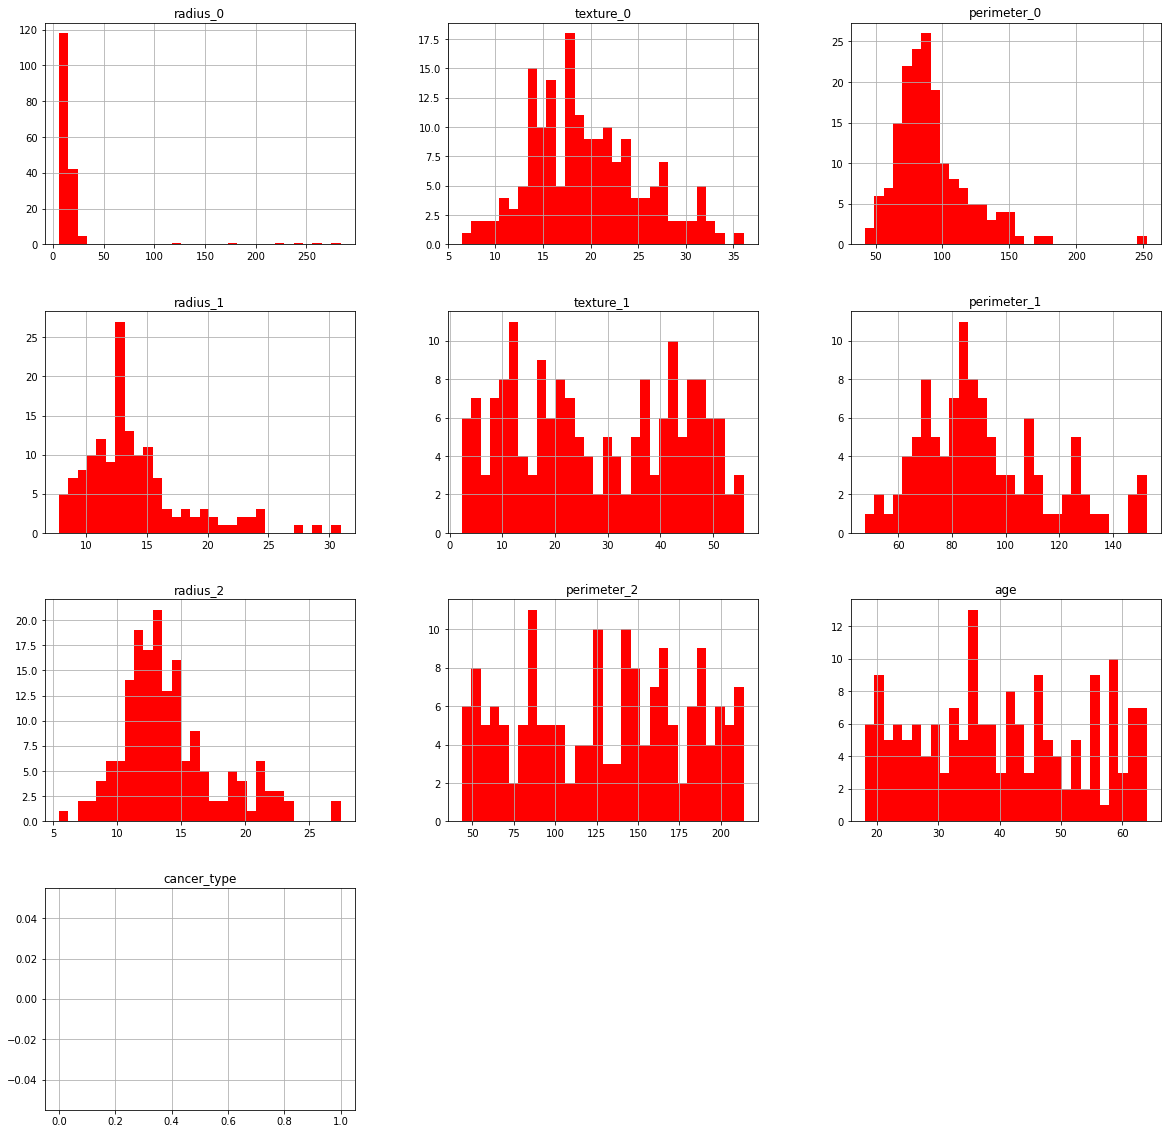

In [ ]:
test_data.hist(bins = 30, figsize = (20,20), color = 'r')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ab53b990>,
      dtype=object)

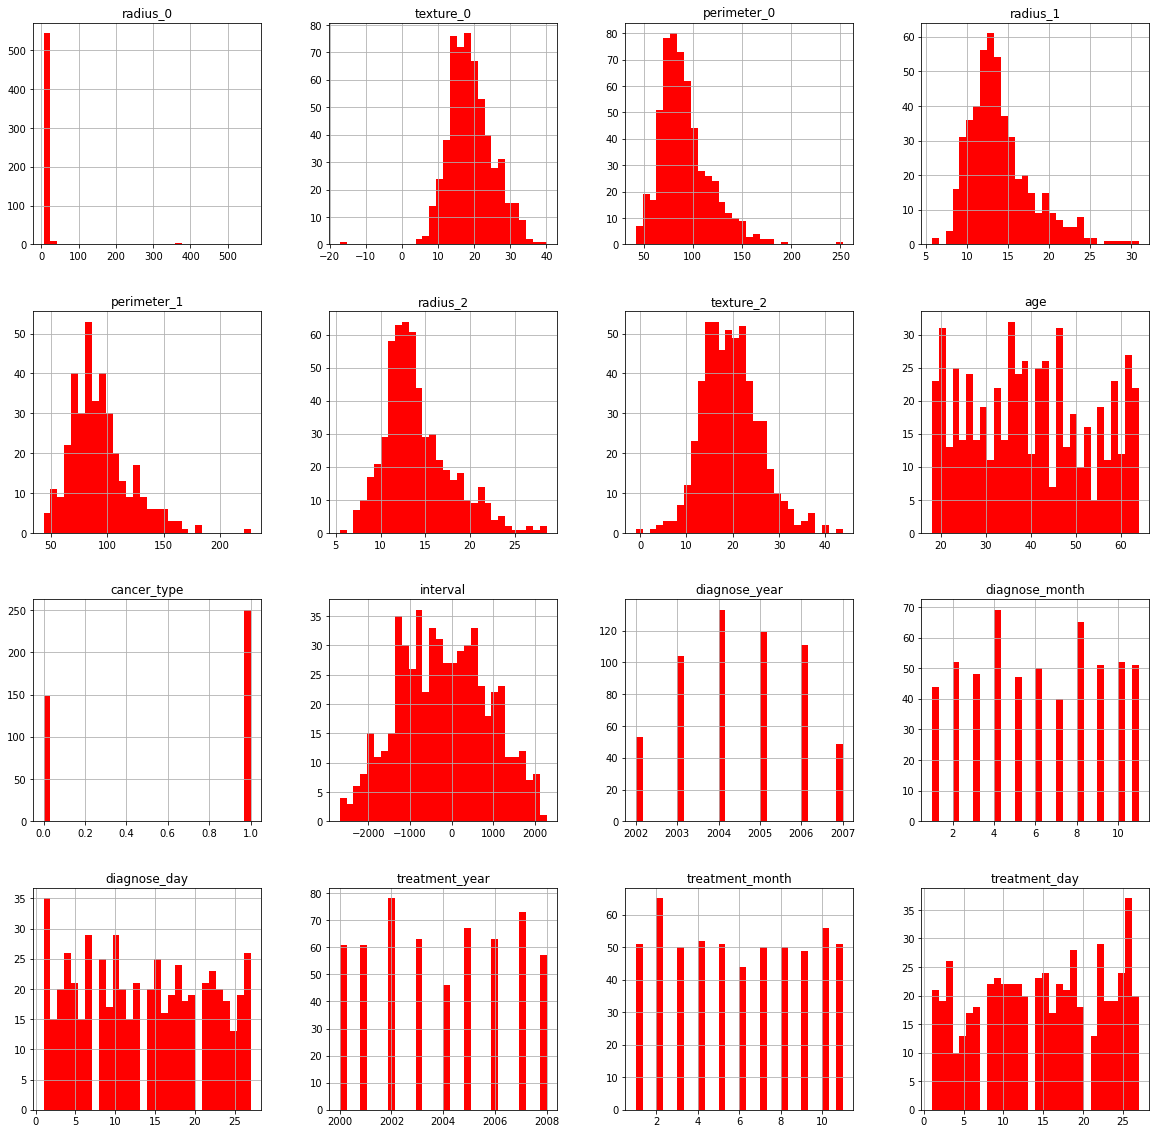

In [ ]:
df_c.hist(bins = 30, figsize = (20,20), color = 'r')

In [ ]:
df_c.describe(include='all')

,radius_0,texture_0,perimeter_0,radius_1,perimeter_1,radius_2,texture_2,age,treatment_date,diagnose_date,cancer_type,label,ind,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day
count,569.000000,569.000000,569.000000,489.000000,369.000000,569.000000,541.000000,569.000000,569,569,398.000000,569,569,569.00000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,513,482,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-04-27 00:00:00,2004-11-04 00:00:00,NaN,train,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,NaN,398,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-09 00:00:00,2002-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-11-26 00:00:00,2007-11-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,21.273693,19.140189,92.143384,14.082352,93.472631,14.120008,19.607541,40.005272,NaN,NaN,0.628141,NaN,NaN,-185.00703,2004.488576,6.050967,13.516696,2003.989455,5.922671,14.662566
std,46.903207,6.148752,26.115440,3.915918,26.337685,3.782700,6.149969,13.427228,NaN,NaN,0.483909,NaN,NaN,1070.52360,1.443889,3.126309,7.905259,2.582422,3.218181,7.821424
min,5.778161,-17.243202,41.982155,5.752395,43.444930,5.429977,-0.966998,18.000000,NaN,NaN,0.000000,NaN,NaN,-2694.00000,2002.000000,1.000000,1.000000,2000.000000,1.000000,1.000000
25%,11.734946,14.760752,74.272633,11.542111,74.997856,11.597654,15.286746,28.000000,NaN,NaN,0.000000,NaN,NaN,-1020.00000,2003.000000,3.000000,7.000000,2002.000000,3.000000,8.000000


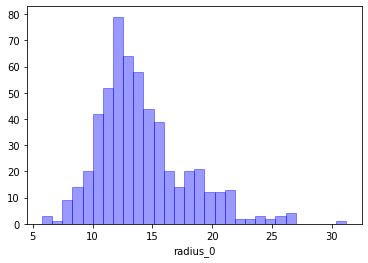

In [ ]:
#replace radius_0 > 200 to nan of radius_0

df_c["radius_0"] = df_c["radius_0"].mask(df_c["radius_0"] >100, np.nan)
sns.distplot(df_c['radius_0'], kde=False, color="blue",bins = 30, hist_kws=dict(edgecolor="b"))

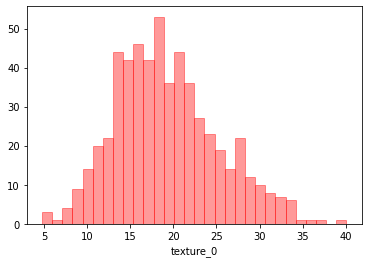

In [ ]:
#replace texture_0 <0 to nan of texture_0
median = df_c['texture_0'].median()

df_c['texture_0'] = np.where(df_c['texture_0'].between(-1000,0), np.nan,df_c['texture_0'])

sns.distplot(df_c['texture_0'], kde=False, color="r", bins = 30, hist_kws=dict(edgecolor="r"))

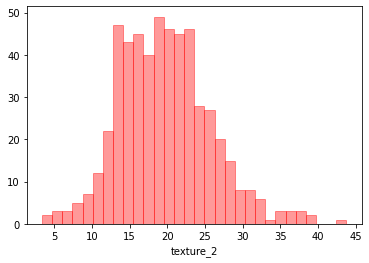

In [ ]:
#replace texture_2 <0 to median of texture_2
median = df_c['texture_2'].median()
median 

df_c['texture_2'] = np.where(df_c['texture_2'].between(-1000,0), np.nan,df_c['texture_2'])

sns.distplot(df_c['texture_2'], kde=False, color="r", bins = 30, hist_kws=dict(edgecolor="r"))

In [ ]:
df_c['radius_mean'] = df_c[['radius_0','radius_1', 'radius_2']].mean(axis=1)
df_c['texture_mean'] = df_c[['texture_0', 'radius_2']].mean(axis=1)
df_c['perimeter_mean'] = df_c[['perimeter_0', 'perimeter_1']].mean(axis=1)

In [ ]:
df_c.groupby('ind').size()

ind
test     171
train    398
dtype: int64

In [ ]:
df_c.isnull().sum()

radius_0            15
texture_0            1
perimeter_0          0
radius_1            80
perimeter_1        200
radius_2             0
texture_2           29
age                  0
treatment_date       0
diagnose_date        0
cancer_type        171
label                0
ind                  0
interval             0
diagnose_year        0
diagnose_month       0
diagnose_day         0
treatment_year       0
treatment_month      0
treatment_day        0
radius_mean          0
texture_mean         0
perimeter_mean       0
dtype: int64

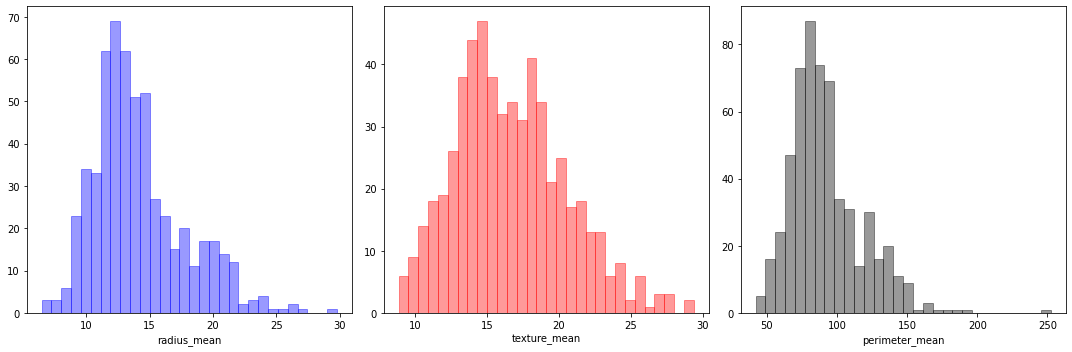

In [ ]:
#data visualization
f, axes = plt.subplots(1, 3, figsize=(15, 5))
#sns.despine(left=True)

sns.distplot(df_c['radius_mean'], kde=False, color="blue",hist_kws=dict(edgecolor="blue"),bins=30, ax=axes[0])
sns.distplot(df_c['texture_mean'], kde=False, color="r",hist_kws=dict(edgecolor="r"),bins=30, ax=axes[1])
sns.distplot(df_c['perimeter_mean'], kde=False, color="k",hist_kws=dict(edgecolor="k"),bins=30, ax=axes[2])


plt.tight_layout()
plt.show()

In [ ]:
#outlier using z-score
#using z score
z = np.abs(stats.zscore(df_c['perimeter_mean']))
print(np.where(z>3))
perimeter_mean = df_c.iloc[np.where(z>3)]
perimeter_mean

(array([ 51, 142, 156, 441, 513]),)


,radius_0,texture_0,perimeter_0,radius_1,perimeter_1,radius_2,texture_2,age,treatment_date,diagnose_date,cancer_type,label,ind,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day,radius_mean,texture_mean,perimeter_mean
51,20.625734,18.144791,179.665832,23.907717,NaN,19.903053,22.984562,55,2003-10-15,2006-08-17,0.0,train,train,-1037,2006,8,17,2003,10,15,21.478835,19.023922,179.665832
142,31.216269,17.723455,152.311798,NaN,227.162938,28.370147,20.103262,18,2003-06-26,2002-09-23,0.0,train,train,276,2002,9,23,2003,6,26,29.793208,23.046801,189.737368
156,26.163750,14.463947,193.755763,NaN,183.114308,25.480741,16.614443,22,2004-07-05,2002-03-27,0.0,train,train,831,2002,3,27,2004,7,5,25.822246,19.972344,188.435035
441,25.694058,32.461840,170.085535,23.557583,NaN,23.202449,22.429694,37,2002-10-11,2004-05-02,NaN,test,test,-569,2004,5,2,2002,10,11,24.151364,27.832145,170.085535
513,26.198745,31.444987,252.398799,30.940587,NaN,23.737824,26.583514,43,2005-10-20,2004-07-10,NaN,test,test,467,2004,7,10,2005,10,20,26.959052,27.591405,252.398799


In [ ]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuwrxa3hu
  JVM stdout: /tmp/tmpuwrxa3hu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuwrxa3hu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_svcfja
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.174 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
#seperate
test_o = df_c[df_c['ind'].eq('test')]
train_o=df_c[df_c['ind'].eq('train')]

In [ ]:
col = ['age','interval','diagnose_year','treatment_year', 'diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean','cancer_type']
df_h= train_o.loc[:, train_o.columns.isin(col)]

In [ ]:
df_h.shape

(398, 12)

In [ ]:
df_h = df_h.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
df_h = df_h.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df_h)

h2o_df['cancer_type'] = h2o_df['cancer_type'].asfactor()
h2o_df['treatment_year'] = h2o_df['treatment_year'].asfactor()
h2o_df['diagnose_year'] = h2o_df['diagnose_year'].asfactor()

h2o_df['treatment_month'] = h2o_df['treatment_month'].asfactor()
h2o_df['diagnose_month'] = h2o_df['diagnose_month'].asfactor()

h2o_df['treatment_day'] = h2o_df['treatment_day'].asfactor()
h2o_df['diagnose_day'] = h2o_df['diagnose_day'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,age,cancer_type,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day,radius_mean,texture_mean,perimeter_mean
type,int,enum,int,enum,enum,enum,enum,enum,enum,real,real,real
mins,18.0,,-2694.0,,,,,,,6.457870819693333,8.847149087375,44.736420411249995
mean,39.87688442211054,,-198.01507537688425,,,,,,,14.149959671445911,16.579277108086917,92.45159539333049
maxs,64.0,,2081.0,,,,,,,29.7932079468,29.39177718655,189.7373681205
sigma,13.427195919801125,,1055.4557408678259,,,,,,,3.582672960239878,3.7859112315823333,25.139138642565726
zeros,0,,0,,,,,,,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,44.0,0,223.0,2005,10,23,2006,6,3,21.3395786903,24.3407442492,127.9240484085
1,59.0,1,-1275.0,2007,8,20,2004,2,22,14.412716978166666,15.383529711,87.91402786225001
2,37.0,0,517.0,2004,8,7,2006,1,6,25.931895342133338,24.9274025588,152.28106161899998


In [ ]:
# Split into 80% training and 20% test dataset
strat_split = h2o_df['cancer_type'].stratified_split(test_frac=0.20, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['age','interval','diagnose_year','treatment_year','diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean']

#feature = ['age','interval','radius_mean','texture_mean', 'perimeter_mean']
#feature = ['age','interval','radius_mean','texture_mean', 'perimeter_mean', 'diagnose_year','treatment_year']
target = 'cancer_type'

In [ ]:
train.shape

(318, 12)

In [ ]:
# Build random forest model
#model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, nfolds =5,mtries=-1, seed=42, score_each_iteration=True, keep_cross_validation_predictions= True)
#model.train(x=feature, y=target, training_frame=train)

In [ ]:
#model.auc(xval=True)

In [ ]:
#model.F1(train=True, xval=True)

In [ ]:
drf_hyper_params = {
                "ntrees" : [i for i in range(5, 105,5)],
                "max_depth": list(range(3, 21)),              
                "sample_rate": [i * 0.1 for i in range(5, 10)]}
grid_search_criteria = {"strategy": "RandomDiscrete", 
                        "max_models": 100, 
                        "seed": 12345}

# Train and validate a random grid of GBMs
model_rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, 
                          hyper_params=drf_hyper_params,
                          search_criteria=grid_search_criteria ,
                          grid_id='model_rf_grid')

model_rf_grid.train(x=feature, y=target, training_frame=train, seed=1)


drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Get the grid results, sorted by validation AUC
model_rf_grid_2 = model_rf_grid.get_grid(sort_by='auc', decreasing=True)
model_rf_grid_2

     max_depth ntrees         sample_rate                model_ids  \
0            9     95  0.7000000000000001   model_rf_grid_model_87   
1            7     45  0.7000000000000001   model_rf_grid_model_12   
2           16     80  0.7000000000000001   model_rf_grid_model_23   
3           17     80  0.7000000000000001   model_rf_grid_model_30   
4           19     85  0.7000000000000001   model_rf_grid_model_94   
5           10     95                 0.5   model_rf_grid_model_15   
6            5     60  0.7000000000000001   model_rf_grid_model_22   
7           15     95  0.6000000000000001   model_rf_grid_model_21   
8           10     95  0.6000000000000001    model_rf_grid_model_8   
9            8     90                 0.5   model_rf_grid_model_66   
10          16     90                 0.5    model_rf_grid_model_3   
11          11    100  0.6000000000000001   model_rf_grid_model_56   
12          14     80                 0.5   model_rf_grid_model_37   
13           8     9

In [ ]:
best_rmf = model_rf_grid_2.models[0]
best_rmf_perf2 = best_rmf.model_performance(test)
best_rmf_perf2.auc()

0.9403333333333334

In [ ]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=95, max_depth=9,
                                 nfolds =5,mtries=-1, seed=42, score_each_iteration=True, sample_rate =0.7, keep_cross_validation_predictions= True)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


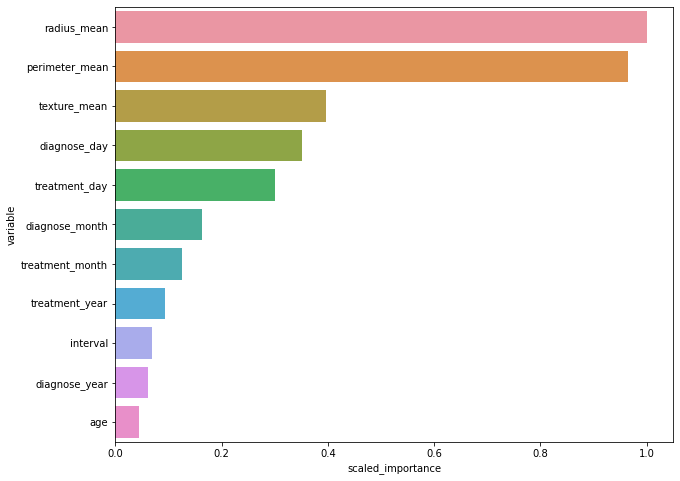

In [ ]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [ ]:
# Make predictions
train_true = train.as_data_frame()['cancer_type'].values
test_true = test.as_data_frame()['cancer_type'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)

train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.89      0.98      0.93        50

    accuracy                           0.91        80
   macro avg       0.93      0.89      0.90        80
weighted avg       0.92      0.91      0.91        80



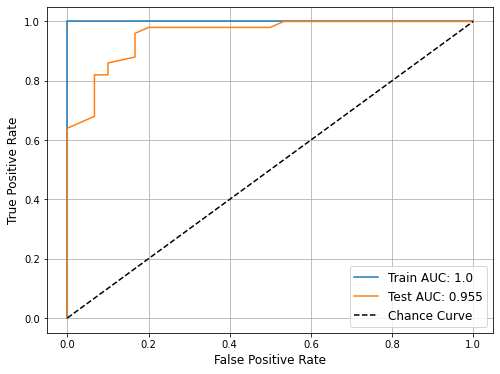

In [ ]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


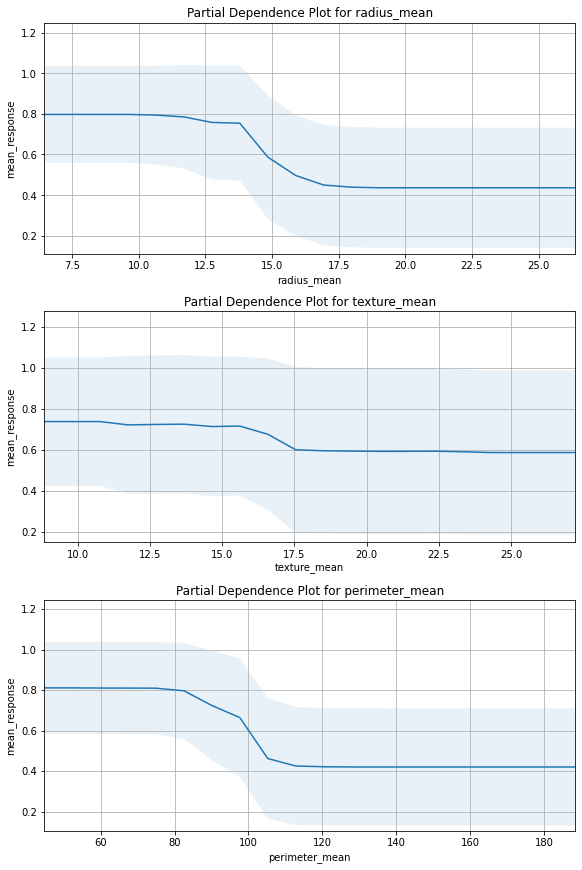

In [ ]:
col = ['age','interval','diagnose_year','treatment_year', 'diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean']
col=['radius_mean','texture_mean', 'perimeter_mean']
_ = model.partial_plot(train, cols=col, figsize=(8, 12))

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


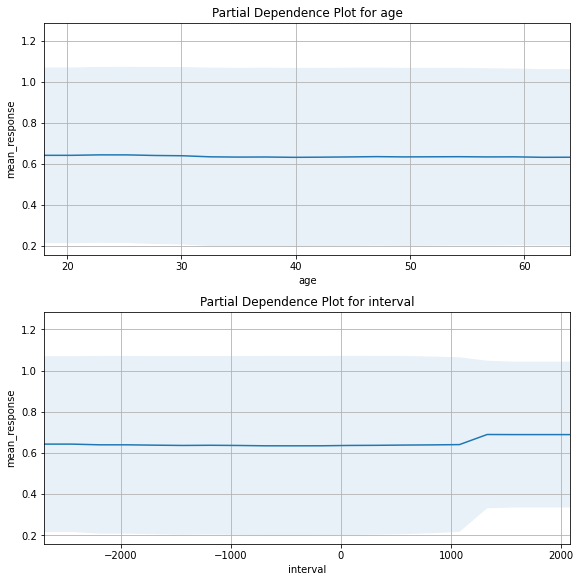

In [ ]:
col = ['age','interval','diagnose_year','treatment_year', 'diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean']
col=['age','interval']
_ = model.partial_plot(train, cols=col, figsize=(8, 8))

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


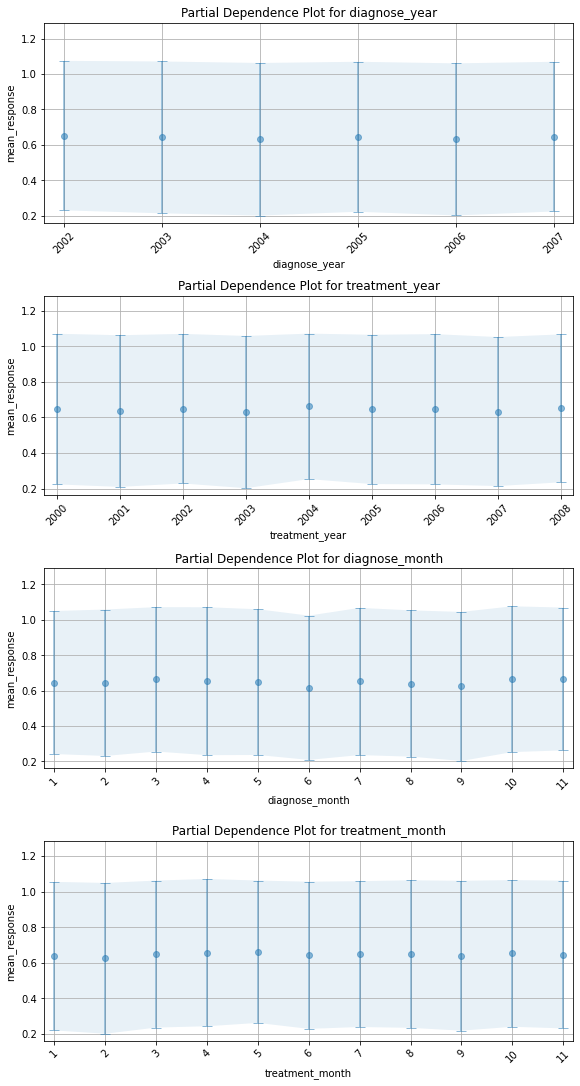

In [ ]:
col = ['age','interval','diagnose_year','treatment_year', 'diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean']
col=['diagnose_year','treatment_year', 'diagnose_month','treatment_month']
_ = model.partial_plot(train, cols=col, figsize=(8, 15))

In [ ]:
model.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5695209251101322: 


,,0,1,Error,Rate
0,0,24.0,6.0,0.2,(6.0/30.0)
1,1,1.0,49.0,0.02,(1.0/50.0)
2,Total,25.0,55.0,0.0875,(7.0/80.0)


In [ ]:
model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5504191008382017: 


,,0,1,Error,Rate
0,0,189.0,8.0,0.0406,(8.0/197.0)
1,1,10.0,190.0,0.05,(10.0/200.0)
2,Total,199.0,198.0,0.0453,(18.0/397.0)


In [ ]:
test_o.describe()

,radius_0,texture_0,perimeter_0,radius_1,perimeter_1,radius_2,texture_2,age,cancer_type,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day,radius_mean,texture_mean,perimeter_mean
count,165.000000,171.000000,171.000000,146.000000,105.000000,171.000000,159.000000,171.000000,0.0,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,14.101021,19.565268,92.177116,13.985507,91.929494,14.085298,19.964179,40.304094,NaN,-154.730994,2004.461988,5.701754,13.923977,2004.005848,6.064327,14.596491,14.033302,16.825283,92.014561
std,3.851041,5.918424,28.292383,4.228770,23.758273,3.872846,6.921250,13.461970,NaN,1107.362908,1.480268,3.117115,8.179606,2.563309,3.331042,7.412691,3.780599,3.989627,27.299476
min,5.778161,6.459678,41.982155,7.739962,47.589153,5.429977,6.052493,18.000000,NaN,-2618.000000,2002.000000,1.000000,1.000000,2000.000000,1.000000,1.000000,6.476480,9.191554,41.982155
25%,11.734946,15.073701,73.821579,11.244488,74.152334,11.636549,14.945064,29.500000,NaN,-920.000000,2003.000000,3.000000,6.500000,2002.000000,3.000000,9.000000,11.587912,14.015322,73.980077
50%,13.220134,18.657451,85.976442,12.987781,86.636101,13.236187,19.061876,39.000000,NaN,-200.000000,2004.000000,5.000000,14.000000,2004.000000,6.000000,15.000000,13.294139,16.448840,86.483692
75%,15.532964,23.360099,104.072392,15.160500,107.123243,15.848764,24.319590,52.000000,NaN,591.500000,2006.000000,8.000000,21.000000,2006.000000,9.000000,21.000000,15.073391,18.876034,101.968966
max,26.526218,36.070789,252.398799,30.940587,152.465833,27.455754,43.773739,64.000000,NaN,2285.000000,2007.000000,11.000000,27.000000,2008.000000,11.000000,27.000000,26.959052,29.300265,252.398799


In [ ]:
col = ['age','interval','diagnose_year','treatment_year', 'diagnose_month','treatment_month','diagnose_day','treatment_day','radius_mean','texture_mean', 'perimeter_mean']
df_test_o= test_o.loc[:, test_o.columns.isin(col)]

In [ ]:
df_test_o.head()

,age,interval,diagnose_year,diagnose_month,diagnose_day,treatment_year,treatment_month,treatment_day,radius_mean,texture_mean,perimeter_mean
398,31,2038,2003,4,22,2008,11,19,11.956118,13.044218,77.106898
399,18,-688,2003,7,7,2001,8,18,13.327773,16.711268,84.005462
400,43,986,2004,3,6,2006,11,17,14.767967,20.436229,90.977022
401,57,-1871,2006,2,24,2001,1,10,14.848593,21.464332,83.032790
402,26,1482,2004,6,21,2008,7,12,9.191477,11.683456,51.583375


In [ ]:
h2o_test_o = H2OFrame(df_test_o)
pred_test=model.predict(h2o_test_o) 

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
y_pred_final=pred_test.as_data_frame()['predict']

In [ ]:
df_predict = pd.DataFrame(y_pred_final)

In [ ]:
df_predict

,predict
0,1
1,1
2,0
3,0
4,1
5,0
6,1
7,1
8,1
9,1


In [ ]:
df_predict.to_csv ('cancer_type_predict_v2.csv', index = False, header=False)

In [ ]:
from google.colab import files
files.download('cancer_type_predict_v2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a356 closed.
